# Regression Example in Tensorflow

## 1. Read In and Inspect Data

In [1]:
import numpy as np       # Basic numerical computing library for Python
import pandas as pd      # Pandas is a useful data manipulation library for Python
import tensorflow as tf  # Really great library for solving hard problems like fizzbuzz

from seaborn import plt                           # Pretty graphs
from sklearn.preprocessing import StandardScaler  # Data normalization

%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
# Pandas makes reading in the data pretty simple.
airfoil_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat",
    sep="\t",
    header=None)

# How many rows and cols in our dataset?
print "Data shape:", airfoil_df.shape
airfoil_df.head()

Data shape: (1503, 6)


,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


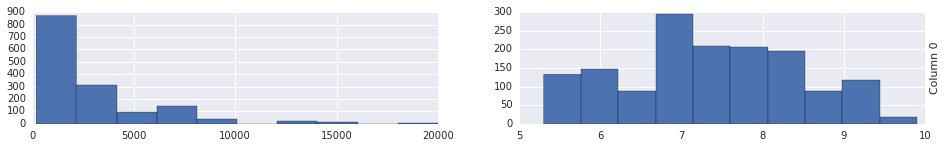

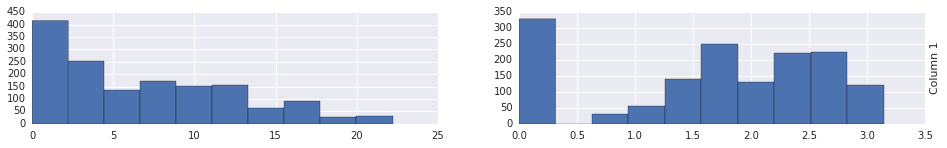

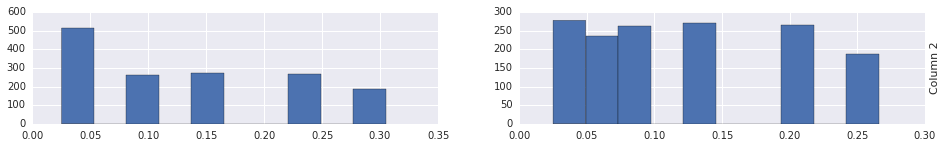

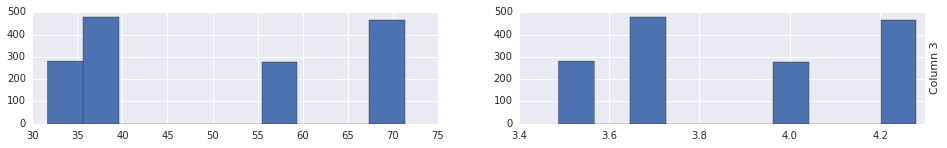

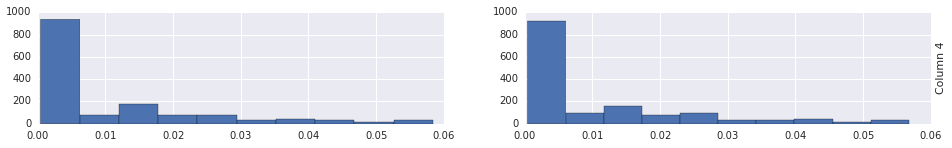

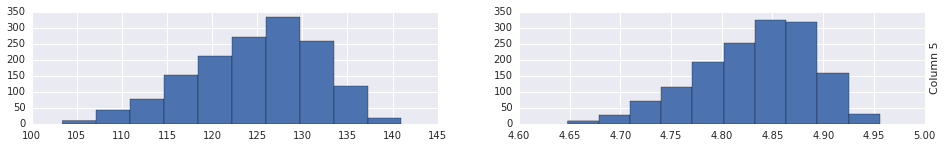

In [3]:
# Inspect the "shape" of each of our columns, plotting raw and log histograms
for col in airfoil_df.columns:
    figsize(16, 2)
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.hist(airfoil_df[col])
    ax2.hist(np.log(airfoil_df[col] + 1))
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel("Column {}".format(col))
    plt.show()

## 2. Preprocess Data and Split Into Training and Test Sets

In [4]:
# Looks like it would be productive to apply a log transform to column 0.
airfoil_df[0] = np.log(airfoil_df[0])

In [5]:
# Split into train and tests sets.
# Since it looks like the data is sorted somehow, we'll shuffle it along the first axis.
# We'll take 80% of the data for training and leave the rest for test.
airfoil = np.array(airfoil_df)
train_set_size = int(airfoil.shape[0] * 0.8)
np.random.shuffle(airfoil)
train = airfoil[:train_set_size]
test = airfoil[train_set_size:]

In [6]:
# To get everything on the same scale, we'll center each column around 0 and
# ensure unit variance. We only use the training set to find mean and variance.
scaler = StandardScaler()
scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

In [7]:
# Split into training features and test targes.
# Looking here: https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise
# It seems like the last column is the response variable.
train_x = train[:, :5]
train_y = train[:, 5]
test_x = test[:, :5]
test_y = test[:, 5]

## 3. Build the Model in TensorFlow

In [8]:
# TF uses a session object to execute your computation graph.
try:
    del(sess)
except Exception as e:
    print "No existing session to delete!"
sess = tf.InteractiveSession()

No existing session to delete!


In [9]:
# Create a placeholder variable for your inputs.
# Inputs are a minibatch of arbitrary depth with 5 features.
features = tf.placeholder(tf.float32, [None, 5], name="Inputs")

# A hidden layer is just a matrix multiplication followed by a nonlinearity.
# We'll project from a space of 5 input features to an overcomplete
# layer of 100 features.
W_hidden = tf.Variable(
    tf.random_normal([5, 100], mean=0, stddev=0.02),
    name="WeightsHidden")
b_hidden = tf.Variable(
    tf.random_normal([100], mean=0, stddev=0.02),
    name="BiasHidden")
h_hidden = tf.nn.relu(tf.matmul(features, W_hidden) + b_hidden)

# To transform the hidden layer to our outputs, we just use another
# matrix multiplication, collapsing from 100 dimensions down to 1.
# Our outputs are sound pressure levels in decibels transformed to have
# zero mean and unit variance, so their range is the real numbers. But
# inspecting the training targets, we don't see anything outside the
# range of -4 to +4, so we can probably use a scaled sigmoid as our
# nonlinearity; we'll project to the range -10 to +10 just to be safe.
W_out = tf.Variable(
    tf.random_normal([100, 1], mean=0, stddev=0.02),
    name="WeightsOut")
b_out = tf.Variable(
    tf.random_normal([1], mean=0, stddev=0.02),
    name="BiasOut")
h_out = tf.reshape(tf.nn.tanh(tf.matmul(h_hidden, W_out) + b_out) * 10.0, [-1])

# Create a placeholder variable for outputs.
# Outputs are a minibatch of arbitrary depth with 1 feature.
targets = tf.placeholder(tf.float32, [None], name="Outputs")

# Error term is the L2 distance between prediction and the target.
err = tf.reduce_mean(tf.square(targets - h_out))

# Use the Adam optimizer with a learning rate of 0.001
train_step = tf.train.AdamOptimizer(0.001).minimize(err)

# Calculate R^2
y_bar = tf.reduce_mean(targets)
ss_tot = tf.reduce_mean(tf.square(targets - y_bar))
r2 = 1 - (err / ss_tot)

# Initialize
sess.run(tf.initialize_all_variables())

## 4. Training and Evaluation

In [10]:
BATCH_SIZE = 64
EPOCHS = 1000
BATCHES_PER_EPOCH = train_x.shape[0] / BATCH_SIZE

train_errs = []
train_r2s = []
test_errs = []
test_r2s = []

test_err, test_r2 = sess.run([err, r2], feed_dict={
    features: test_x,
    targets: test_y})
test_errs.append(test_err)
test_r2s.append(test_r2)

for epoch in range(EPOCHS):
    if epoch % 20 == 0:
        print "Epoch {ep:03d}; Error = {te:.4f}; R2 = {r2:.3f}\t".format(
            ep=epoch, te=test_err, r2=test_r2)
    
    # Shuffle the training data
    indices = np.arange(train_x.shape[0])
    np.random.shuffle(indices)
    train_x_ep = train_x[indices]
    train_y_ep = train_y[indices]
    
    # Train
    for batch in range(BATCHES_PER_EPOCH):
        start_offset = batch * BATCH_SIZE
        stop_offset = start_offset + BATCH_SIZE
        _, train_err, train_r2 = sess.run([train_step, err, r2], feed_dict={
            features: train_x_ep[start_offset:stop_offset],
            targets: train_y_ep[start_offset:stop_offset]})
        train_errs.append(train_err)
        train_r2s.append(train_r2)
    
    # Evaluate
    test_err, test_r2 = sess.run([err, r2], feed_dict={
        features: test_x,
        targets: test_y})
    test_errs.append(test_err)
    test_r2s.append(test_r2)

Epoch 000; Error = 0.9650; R2 = -0.016	
Epoch 020; Error = 0.1441; R2 = 0.848	
Epoch 040; Error = 0.0971; R2 = 0.898	
Epoch 060; Error = 0.0861; R2 = 0.909	
Epoch 080; Error = 0.0807; R2 = 0.915	
Epoch 100; Error = 0.0781; R2 = 0.918	
Epoch 120; Error = 0.0738; R2 = 0.922	
Epoch 140; Error = 0.0711; R2 = 0.925	
Epoch 160; Error = 0.0719; R2 = 0.924	
Epoch 180; Error = 0.0695; R2 = 0.927	
Epoch 200; Error = 0.0664; R2 = 0.930	
Epoch 220; Error = 0.0668; R2 = 0.930	
Epoch 240; Error = 0.0630; R2 = 0.934	
Epoch 260; Error = 0.0662; R2 = 0.930	
Epoch 280; Error = 0.0625; R2 = 0.934	
Epoch 300; Error = 0.0631; R2 = 0.934	
Epoch 320; Error = 0.0680; R2 = 0.928	
Epoch 340; Error = 0.0672; R2 = 0.929	
Epoch 360; Error = 0.0676; R2 = 0.929	
Epoch 380; Error = 0.0616; R2 = 0.935	
Epoch 400; Error = 0.0677; R2 = 0.929	
Epoch 420; Error = 0.0591; R2 = 0.938	
Epoch 440; Error = 0.0599; R2 = 0.937	
Epoch 460; Error = 0.0630; R2 = 0.934	
Epoch 480; Error = 0.0580; R2 = 0.939	
Epoch 500; Error = 0.061

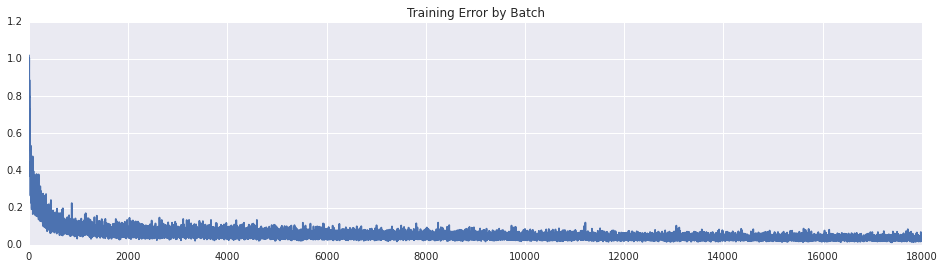

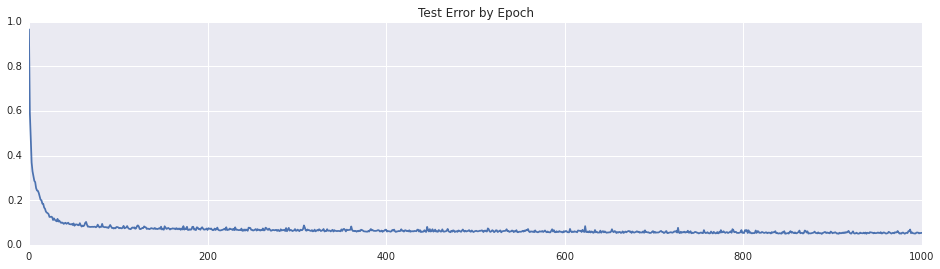

In [11]:
figsize(16, 4)

plt.plot(np.arange(len(train_errs)), train_errs)
plt.title("Training Error by Batch")
plt.show()

plt.plot(np.arange(len(test_errs)), test_errs)
plt.title("Test Error by Epoch")
plt.show()

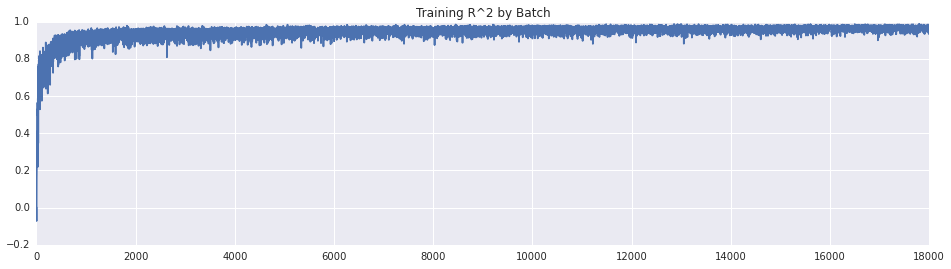

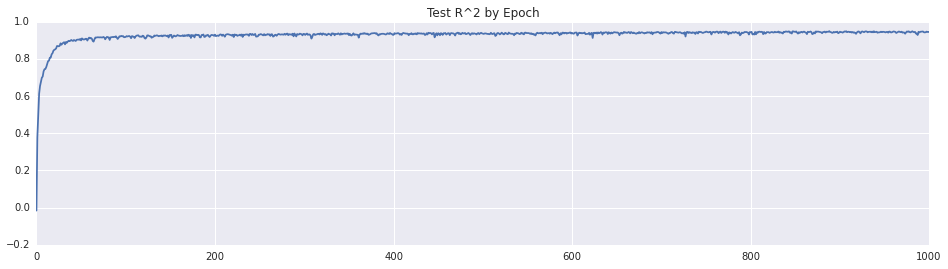

In [12]:
figsize(16, 4)

plt.plot(np.arange(len(train_r2s)), train_r2s)
plt.title("Training R^2 by Batch")
plt.show()

plt.plot(np.arange(len(test_r2s)), test_r2s)
plt.title("Test R^2 by Epoch")
plt.show()